# Replicating results from "Modeling COVID19 mortality in the US: Community context and mobility matter "

Modeling analyses after the work done in this [paper](https://www.medrxiv.org/content/10.1101/2020.06.18.20134122v1.full.pdf).

**Paper Data**:
- Chicago, detroit, los angeles, new orleans, new york (median of each encompassed county statistic used), san francisco, seattle
- Sociodemographic data, economic indicators, demographics, documented risk factors, daily PM_2.5, comorbidity data
- Google mobility data at retail and recreation centers as %-change in baseline. 5 day moving average as imputation
- PCA reduced sociodemographic and comorbidity data. Top 4 components (80% of variation explained) used and classified by most important features in each.
- Target: daily *cumulative* COVID deaths

**Paper Model**
- quasi-Poisson GAM
- 30 days of lagged mobility & sociodemographic PCs fitted
- log(population) offset (i.e. target is deaths per capita)

$$Y_t \sim Poisson(\mu_t)$$
$$E(Y_t) = \mu_t \quad\quad Var(Y_t) = \psi \mu_t$$
$$log(E(Y_t)) = \beta_0 + f(time_t) + f_{county}(time_t) + \sum_{i=1}^4 f(PC_i) + f(mobility_{t-0}, \dots, mobility_{t-30})$$

- $f(time_t)$: common epidemic trajectory across counties (thin-plate regression spline)
- $f_{county}(time_t)$: county specfici epidemic trajectory (factor-smooth interaction)
- $f(PC_i)$: cubic regression spline w/ 5 knots
- $f(mobility_{t-0}, \dots, mobility_{t-30})$ tensor product of penalized spline of mobility at time t till t-30 days.
    - Smoothing parameter fit using restricted max-likelihood (REML) R *mgcv*
    - See DLNM package in R

**Interpretation**
- Confidence intervals estimated with parametric bootstrapping (bias-corrected)
- magnitude of F-statistic for individual predictors used as a proxy for explanatory power.
- partial dependency plots

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pickle
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *
from src.utils.dates import get_today, lag_date, date2str, str2date, get_format
from src.utils.df_utils import get_date_columns
from src.pandas.align import align_lagged_dates

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import spearmanr

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
n_days = 30
mobility_lag = 30

In [4]:
df = get_time_series_dataframe(
    n_days=n_days,
    mobility_lag=mobility_lag,
    county_features = [
        'FIPS',
        'Rural-urban_Continuum Code_2013',
        'Density per square mile of land area - Population',
        'Density per square mile of land area - Housing units',
        'Percent of adults with less than a high school diploma 2014-18',
        'PCTPOVALL_2018',
        'Unemployment_rate_2018',
        'Total_age65plus', 
        'POP_ESTIMATE_2018',
        'MEDHHINC_2018',
        "Percent of adults with a bachelor's degree or higher 2014-18",
        "Percent of adults with a high school diploma only 2014-18",
        "Unemployment_rate_2018",
        "Total households!!Average household size",
        "HospCt",
        "Beds",
    ]
)

In [5]:
df_timeseries = pd.concat(
    [df[
        ['FIPS'] + ['onset_relative'] +
        [f'deaths_{d+1:02d}'] + 
        [f'mobility_{d+m+1:02d}' for m in range(mobility_lag)]]
     .assign(dt=d+1).rename({
        f'deaths_{d+1:02d}':'deaths',
        **{f'mobility_{d+m+1:02d}':f't{m}' for m in range(mobility_lag)}
    }, axis=1) for d in range(n_days)],
    axis=0
)

In [6]:
df_predictors = df[[
    'FIPS',
    'Rural-urban_Continuum Code_2013',
    'Density per square mile of land area - Population',
    'Density per square mile of land area - Housing units',
    'Percent of adults with less than a high school diploma 2014-18',
    'PCTPOVALL_2018',
    'Unemployment_rate_2018',
    'Total_age65plus', 
    'POP_ESTIMATE_2018',
    'MEDHHINC_2018',
    "Percent of adults with a bachelor's degree or higher 2014-18",
    "Percent of adults with a high school diploma only 2014-18",
    "Unemployment_rate_2018",
    "Total households!!Average household size",
]]
df_hypothesis = df[[
    "FIPS",
    "HospCt",
    "Beds",
]]

In [7]:
df_predictors['Pct_age65plus'] = df_predictors['Total_age65plus'] / df_predictors['POP_ESTIMATE_2018']

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
X = df_predictors[[
    'Density per square mile of land area - Population',
    'Density per square mile of land area - Housing units',
    'Percent of adults with less than a high school diploma 2014-18',
    'PCTPOVALL_2018',
    'Unemployment_rate_2018',
    'Pct_age65plus', 
    'POP_ESTIMATE_2018',
    'MEDHHINC_2018',
    "Percent of adults with a bachelor's degree or higher 2014-18",
    "Percent of adults with a high school diploma only 2014-18",
    "Unemployment_rate_2018",
    "Total households!!Average household size"
]].values.copy()

In [9]:
X = StandardScaler().fit_transform(X)

In [10]:
pca = PCA(n_components=11, svd_solver='full')
X = pca.fit_transform(X)

Text(0.5, 1.0, 'Explained PCA variance')

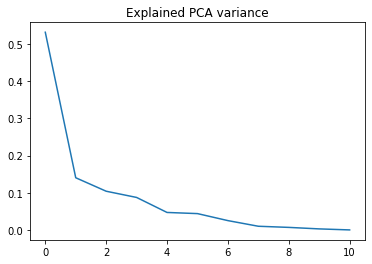

In [11]:
plt.plot(np.arange(X.shape[1]), pca.explained_variance_ratio_); plt.title('Explained Variance')
plt.title(f'Explained PCA variance')

In [12]:
for i in range(4):
    df_predictors[f'PCA{i}'] = X[:,i]

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
df_X = pd.merge(df_timeseries, pd.merge(df_predictors, df_hypothesis, on='FIPS'), on='FIPS')

In [14]:
df_X['deaths'] = df_X['deaths'] / df_X['POP_ESTIMATE_2018']

In [1]:
from pygam import f, s, te
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

In [16]:
county_fips = [
    "06001",
    "06037",
    "06059",
    "06075",
    "06081",
    "06085",
    "17031",
    "17043",
    "17089",
    "17097",
    "17111",
    "17197",
    "18089",
    "22051",
    "22071",
    "22075",
    "22087",
    "22103",
    "26099",
    "26125",
    "26163",
    "53033",
    "53061",
]
predictor_vars = [
    "onset_relative",
    "PCA0",
    "PCA1",
    "PCA2",
    "PCA3",
    "HospCt",
    "Beds",
] + [f't{m}' for m in range(mobility_lag)]
target_var = 'deaths'

X = df_X[df_X['FIPS'].isin(county_fips)][predictor_vars].values
y = df_X[df_X['FIPS'].isin(county_fips)][target_var].values

In [17]:
scaler = MinMaxScaler()
X[:,1:] = scaler.fit_transform(X[:,1:])

In [18]:
ggam = GammaGAM(
    f(1) +
    s(1, n_splines=5, lam=0) +
    s(2, n_splines=5, lam=0) +
    s(3, n_splines=5, lam=0) +
    s(4, n_splines=5, lam=0) +
    s(5, n_splines=5, lam=0) +
    s(6, n_splines=5, lam=0) +
    te(7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36, lam=1)
)

In [305]:
# lams = np.random.rand(100, 37) # random points on [0, 1], with shape (100, 3)
# lams = lams * 8 - 3 # shift values to -3, 3
# lams = np.exp(lams) # transforms values to 1e-3, 1e3

# ggam.gridsearch(X, y, lam=lams)

In [ ]:
results = ggam.fit(X,y)

In [ ]:
results.save('../ggam-25-results.pkl')